In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [ ]:
# let's start with a simple function which is a parabola (quadratic)
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, 0.25)  # start, stop, step. np.arange is like range, but returns a numpy array
print(type(xs))
ys = f(xs)
plt.plot(xs, ys)  # this gives us a parabola which is concave upx

# Derivatives
- now we want to find the slope of the tangent line at a point
- it's measuring the rate of change of the function at a point (how fast the function is changing)
- rise over run


In [ ]:
# h is the change in x and is very small
h = 0.000001
x = 2 / 3  # this is optimimum for the parabola i.e. the slope is 0 (local minimum)
(f(x + h) - f(x)) / h  # normalised by h to make it a slope

In [ ]:
# lets get more complex, i.e. a function with multiple inputs with a single output d
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

# Tip
The derivative of a function tells you how much the function changes when you make a small change to one of its inputs. In this case, we want to find the derivative of a*b + c with respect to the variable a. This means we want to know how much the value of the function changes when we make a small change to the value of a.

The statement says that the derivative of a*b + c with respect to a is simply b. This means that if we change a by a small amount, the value of the function will change by approximately b times that small amount.

In [ ]:
# we can find the derivative of d with respect to a
h = 0.0001  # small change

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c  # original value
a += h  # change a by a small amount
d2 = a * b + c  # new value

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)  # i.e. derivative of d with respect to a is b = -3.0


# Derivatives of a function with multiple inputs
- we can use the chain rule to find the derivative of a function with multiple inputs
- the derivative of a function with multiple inputs is the sum of the partial derivatives of each input
- the partial derivative of a function with respect to a variable is the derivative of the function with respect to that variable, holding all other variables constant

# Class Features
- we want to create a class which can store a value and its gradient
- we want to be able to add and multiply values
- we want to be able to apply a non-linear activation function
- we want to be able to backpropagate the gradient through the graph
- we want to be able to visualise the graph
- we want to be able to update the value of a variable

### Objective
- We want to create data structures that's scalable and efficient
- Create connecting tissue between the data structures to get lineage (i.e. leave nodes)

In [3]:
class Value:
    # this is the constructor
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # this will maintain the derivative of L with respect to the node. Initialised to 0 which essentially means it doesn't "yet" effect the output value of the loss function
        self._backward = lambda: None # it initialises the function to do nothing, and we use a lambda function because it's a one liner
        self._prev = set(_children)  # this gives us the lineage of the node ie what nodes are connected to it
        self._op = _op  # this tells us the operation that was performed on the node
        self.label = label  # this is the label of the node

    def __repr__(self):
        return f"Value(data={self.data})"

    # this is the forward pass by using these private methods (i.e. __add__ and __mul__)
    # we use double underscores to make the method private and because the arguments are integers we can use the + and * operators which would have otherwise concatenated strings
    # create a backward private method which will be used in the backpropagation algorithm
        # use the chain rule: multiply the data of the node by the gradient of the output node
        # we return the function, so we don't execute it immediately
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # chain rule: for adding we just propogate as-is
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # chain rule: we criss-cross the data of the nodes TIMES the gradient of the output node
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):  # tanh is a non-linear activation function
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            # chain rule: we TIMES the data of the node by the gradient of the output node
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def backward(self):  # this is the backpropagation algorithm

        topo = []
        visited = set()  # set does not allow duplicates and is unordered and unindexed (faster than list)

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b;
e.label = 'e'
d = e + c;
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f;
L.label = 'L'
L

Value(data=-8.0)

In [7]:
from graphviz import Digraph


def trace(root):
    # is a helper function for draw_dot to help build a set of all nodes and edges in a graph
    nodes, edges = set(), set()  # set does not allow duplicates and is unordered and unindexed (faster than list)

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid,
                 label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
                 # label="{ %s | data %.4f | <b>grad</b> %.4f }" % (n.label, n.data, n.grad),
                 shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [ ]:
L.grad = 1.0 # derivative of L with respect to L is 1 so can be set manually
# likewise the derivative of L with respect to d and f can also be set manually because these are the last hidden layer
d.grad = -2
f.grad = -4
draw_dot(L)

# ⭐️Explain in simple terms⭐️
Now lets see how sensitive are changes in C and E to the output of the loss function**

dd / dc = ?

- consider this derivative function
`(f(x + h) - f(x)) / h i.e. change in f(x) / change in x`
- substitute with the function we're interested in
`((c + h) + e) - (c + e)) / h`
- now expand out
`(c + h + e - c - e) / h`
- now simplify
`(h + 0) / h = 1`

## Key takeaways
- What this tells us that if we change c by a small amount L will change by the same amount
- By symmetry, the same is true for dd / de = 1
- NB however these are local (derivative) changes and not global changes which are calculated using the chain rule


# Chain Rule

- see this [video](https://www.youtube.com/watch?v=IwUJwQYQHkE) for a good explanation of the chain rule or this wikipedia [article](https://en.wikipedia.org/wiki/Chain_rule)
    - here's a snippet from the wikipedia article:
        - "Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.
        - As put by George F. Simmons: "if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."
- therefore `dL / dc = (dL / dd) * (dd / dc) = -2 * 1 = -2`
- ⭐️ think of any positive operators as simply routing the gradient through the expression graph

In [ ]:
# therefore we can manually add the gradient to the c and e nodes
c.grad += -2
e.grad += -2
draw_dot(L)
#

# now lets manually create the gradient for a and b
- we know that `dl/de = -2`
- we know that the local gradient of `de/da = b` and `de/db = a`
- ∴ `dl/da = dl/de * de/da = -2 * -3 = 6`
- ∴ `dl/db = dl/de * de/db = -2 * 2 = -4`

In [ ]:
# therefore set these gradients manually
a.grad += 6
b.grad += -4
draw_dot(L)


In [ ]:
# <editor-fold desc="Single optimser step">
# where we want to L to go up by 0.01 ie. in the direction of the gradient,
# so we nudge the leaf nodes in the direction of the gradient that we have control over
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# mimic a forward pass
e = a * b
d = e + c
L = d * f

print(L.data)
# </editor-fold>

# # <editor-fold desc="reset the data">
# a.data = 2.0
# b.data = -3.0
# c.data = 10.0
# f.data = -2.0
# # mimic a forward pass
# e = a * b
# d = e + c
# L = d * f
# print(L.data)
# # </editor-fold>




In [ ]:
# this is just sandpit code to do an inline gradient check FOR ALL THE ABOVE manually created
# this is different to numerical gradient which is estimating using small step sizes
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    d.data += h # derivative of L with respect to d should be f so can be set manually i.e. -2
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


lol()

# Backpropagation
- we want to be able to backpropagate the gradient through the graph i.e. calculate the gradient of the loss with respect to each variable
- we're interested in the derivative of the Loss function with respect to the weights of the neural network and need to know how these weights are impacting the loss function
- remember only the weights change and iterated on using the gradient descent algorithm

## Example of a mathematical model of a neuron

![Mathematical model of a neuron](../micrograd/images/Mathematical-model-of-a-biological-neuron.ppm)


- Now we're going to backpropagate through a neuron in a neural network (which is a multi-layer perceptron)
- Use tanh as the activation function which is a sigmoid function that is zero centered whereas sigmoid is not
- the activation function is a squashing function that squashes the output of the neuron to be between -1 and 1

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));
plt.grid();

In [4]:
# Now let's do a dot.product of the inputs and weights and add the bias
# deliberately broken down to then be able
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron. This number was deliberately chosen
b = Value(6.8813735870195432, label='b') # this is the bias that makes the neuron fire when the inputs are 0,0. It's deliberately chosen as 6.8813735870195432 to ...
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1;
x1w1.label = 'x1*w1'
x2w2 = x2 * w2;
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b;
n.label = 'n'
o = n.tanh(); # tanh is a hyperbolic function that needs more than just pluses and times because you also need exponentiation
o.label = 'o'

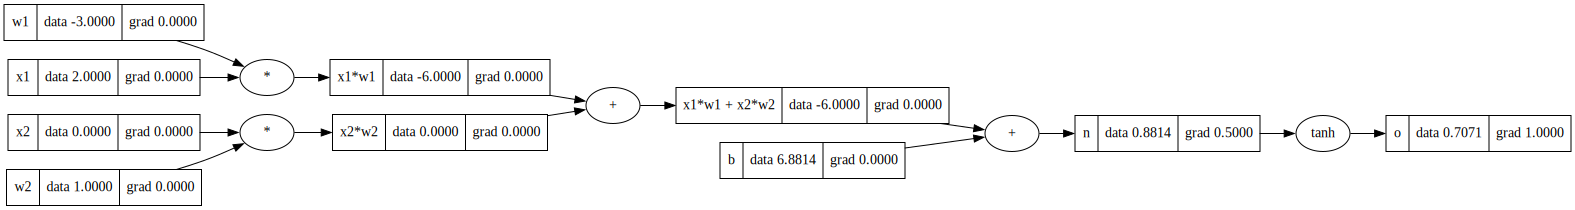

In [10]:
draw_dot(o)


### SJ: RESUME here
- [1:16:04](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)
- FORK and push this repo to your own github account

In [9]:
o.grad = 1.0
o._backward()

In [ ]:
# SJ: lets fix some gradients
o.grad = 1.0
# for n, we need to calculate the derivative of the tanh function
# do/dn = 1 - tanh(n)^2 = 1 - o^2
n_grad = 1 - o.data ** 2 # this is the derivative of the tanh function, see https://en.wikipedia.org/wiki/Hyperbolic_functions#Tanh (derivatices section)
print(f"n_grad = {n_grad}")
n.grad = n_grad

In [ ]:
draw_dot(root=o)


## SJ: lets continue the backpropagation
- remember the gradient is the derivative of the loss function with respect to the variable
- remember a plus is a distributor so we can distribute the gradient to the two inputs i.e. flow back the same gradient to both inputs
- for the 1st input layer, for multiplication the local gradient/derivative is the other term


In [ ]:
# SJ first lets set the gradient for the 2 intermediate layers where we're adding
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5


In [ ]:
# SJ for the 1st layer, for multiplication it's always the other term so we can do a local chain rule
x2.grad = w2.data * x2w2.grad # for x2 it will be (the other term's data w2) * (the gradient of the next layer x2w2)
w2.grad = x2.data * x2w2.grad # NB. the derivative tells the sensitivity of the output to this weight w2 which in this case is zero

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# this completes this MANUAL back propagation and tells us that: (1) w2 has no bearing but w1 does in a positive manner and will be proportionate because the gradient is 1.0

In [ ]:
# SJ: Could have simplied this using numpy dot product
import numpy as np


# Define the input vectors x and w as NumPy arrays
x = np.array([x1, x2])
w = np.array([w1, w2])

# Calculate the dot product of x and w using the dot function
xw = np.dot(x, w)

# xw will contain the result of x1w1 + x2w2
draw_dot(xw)

In [ ]:
o.backward()

In [ ]:
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
topo

In [ ]:
o.grad = 1.0 # we manually set this first

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
n.grad = 0.5

In [ ]:
o.grad = 1.0

In [ ]:
1 - o.data ** 2

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2

In [ ]:
a = Value(3.0, label='a')
b = a + a;
b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b;
d.label = 'd'
e = a + b;
e.label = 'e'
f = d * e;
f.label = 'f'

f.backward()

draw_dot(f)